In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import glob
import arviz 
import os
import seaborn as sns
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.backends.backend_pdf as backend_pdf
from scipy.stats import gaussian_kde


In [19]:

def load_mcmc_results(filepath_pattern):
    """
    Load MCMC results from pickle files matching the given pattern.
    
    Args:
        filepath_pattern: Pattern to match pickle files (e.g., "results/chain_*.pkl")
        
    Returns:
        List of loaded results
    """
    results = []
    for filepath in sorted(glob.glob(filepath_pattern)):
        print(f"Loading {filepath}")
        with open(filepath, 'rb') as f:
            results.append(pickle.load(f))
    return results


def compute_diagnostics(chain_results, burnin_percent):
    trees = np.array([chain_results[i]['trees'] for i in range(len(chain_results))])
    trees = trees[:, int(burnin_percent*trees.shape[1]):, :, :]  # discard burnin
    rhats = []
    esss = []
    for idx in range(trees.shape[2]):  # calculate for all nodes 
        innernodes = trees[:,:,idx, :]
        keys = list(range(innernodes.shape[2]))
        MCMCres = arviz.convert_to_dataset({k:innernodes[:,:,i] for i,k in enumerate(keys)})
        rhats.append(arviz.rhat(MCMCres).to_array().to_numpy())
        esss.append(arviz.ess(MCMCres).to_array().to_numpy())
    return {'Rhat': np.array(rhats), 'ESS': np.array(esss)}


def plot_traces(results, burnin_percent, node_idx, save_path, diagnostics=None, true_values=None): 
    colors = sns.color_palette('pastel', len(results))
    pdf = backend_pdf.PdfPages(save_path + f'/trace_burnin_percent={burnin_percent}.pdf')
    burnin_end = int(results[0]['trees'].shape[0] * burnin_percent)
    plt.figure(1)

    for idx in node_idx: 
        fig, axes = plt.subplots(nrows=7, ncols=6, figsize=(25,15), sharex=True)
        fig.subplots_adjust(top=0.9)  # Adjust this value between 0 and 1
        if true_values is not None: 
            true_innernode = true_values[idx,:]
        for j in range(len(results)): # loop over chains
            innernode = results[j]['trees'][:,idx, :]
            curcol = colors[j]
            for i, ax in zip(range(innernode.shape[1]), axes.flat): # loop over dimensions
                ax.plot(innernode[burnin_end::,i], color = curcol, alpha=0.5)
                if diagnostics:
                    cur_ess = round(diagnostics['ESS'][idx][i], 2)
                    cur_rhat = round(diagnostics['Rhat'][idx][i], 2)
                if true_values is not None:
                    ax.hlines(y=true_innernode[i], xmin=0, xmax=innernode.shape[0]-burnin_end, color='skyblue')
                ax.set_title(f'{i}, Rhat={cur_rhat}, ESS: {cur_ess}')
        fig.suptitle(f'Node {idx}', size=25)
        pdf.savefig()
        plt.clf()
    pdf.close();
    
    
    
# define function for plotting parameter traces
def plot_parameter_traces(chain_results, param_names, burnin_percent, savepath=None):
    """
    Plot the traces of MCMC parameters.
    
    Args:
        chain_results: List of MCMC result dictionaries
        param_names: List of parameter names to plot
        burnin_percent: Percentage of samples to discard as burn-in
    """
    burnin_index = int(burnin_percent * len(chain_results[0][param_names[0]]))
    num_params = len(param_names)
    plt.figure(figsize=(15, 5 * num_params))
    
    # compute convergence diagnostics
    sigmas = [chain_results[i]['sigma'] for i in range(len(chain_results)) if chain_results[i] is not None]
    alphas = [chain_results[i]['alpha'] for i in range(len(chain_results)) if chain_results[i] is not None]
    MCMC_result = dict(zip(["alpha", "sigma"], [alphas, sigmas])) 
    parsres = arviz.convert_to_dataset(MCMC_result)
    rhat = arviz.rhat(parsres)
    ess = arviz.ess(parsres)
    
    for i, param in enumerate(param_names):
        plt.subplot(num_params, 1, i + 1)
        for j in range(len(chain_results)):
            if chain_results[j] is not None:
                plt.plot(chain_results[j][param][burnin_index:], label=f'Chain {j}')
        plt.xlabel('Iteration')
        plt.ylabel(param)
        plt.title(f'MCMC Trace for {param} (R-hat: {rhat[param]:.2f}, ESS: {ess[param]:.1f})')
        plt.legend()
    
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show()

def plot_log_posterior(result, burnin_percent, save_path=None): 
    """
    Plot the posterior distribution of the MCMC results.
    
    Args:
        result: MCMC result dictionary
        burnin_percent: Percentage of samples to discard as burn-in
    """
    # Compute burn-in index
    burnin_index = int(burnin_percent * len(result[0]['log_posterior']))
    
    # Plot log posterior
    plt.figure(figsize=(10, 5))
    [plt.plot(result[i]['log_posterior'][burnin_index:], label=f'Chain {i}')
     for i in range(len(result))]
    plt.xlabel('Iteration')
    plt.ylabel('Log Posterior')
    plt.title('MCMC Log Posterior Trace')
    plt.legend()
    if save_path:
        plt.savefig(save_path)
    plt.show()
    
def plot_samples_from_posterior(chain_results, burnin_percent, node_idx, sample_every, savepath, true_values=None):
    pdf = backend_pdf.PdfPages(savepath + f'/samples-posterior-sample_n={sample_every}_burnin_percent={burnin_percent}.pdf')
    
    burnin_end = int(chain_results[0]['trees'].shape[0] * burnin_percent)
    
    for idx in node_idx: # loop over innernodes
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
        
        # Get all samples from all chains
        all_samples = []
        for j in range(len(chain_results)):
            # Make sure we have data after burnin
            post_burnin_data = chain_results[j]['trees'][burnin_end:, idx, :]
            #print(post_burnin_data)
            
            if len(post_burnin_data) > 0:
                thinned_data = post_burnin_data[0::sample_every, :]
                all_samples.append(thinned_data)
        
        # Combine all chains
        if all_samples:
            innernodes = np.vstack(all_samples)
            
            # Debug info
            print(f"Node {idx}: Found {len(innernodes)} samples, shape={innernodes.shape}")
            
            # Close the shape by appending first landmarks
            inode = np.append(innernodes, innernodes[:, 0:2], axis=1)
            
            # Plot each shape sample
            for i in range(inode.shape[0]):
                x_coords = inode[i, ::2]  # Every other element, starting at 0 (x coordinates)
                y_coords = inode[i, 1::2]  # Every other element, starting at 1 (y coordinates)
                axes.plot(x_coords, y_coords, '--.', color='steelblue', alpha=0.3)
            
            # Add true values if provided
            if true_values is not None:
                true_innernode = true_values[idx, :]
                tinode = np.concatenate((true_innernode, true_innernode[0:2]))  
                axes.plot(tinode[::2], tinode[1::2], '--.', color='black', linewidth=2, label='true shape')
            
            # Add title and format
            fig.suptitle(f'Node {idx}', size=25)
            fig.tight_layout()
            axes.set_aspect('equal')  # Equal aspect ratio
            axes.grid(True, alpha=0.3)
            
            # Save the figure
            pdf.savefig(fig)
            
        plt.close(fig)  # Close the figure to free memory
    
    pdf.close()  # Close the PDF
    print(f"Saved plots to {savepath}/samples-posterior-sample_n={sample_every}_burnin_percent={burnin_percent}.pdf")




    

# Visualize results


In [57]:
burnin_percent = 0.3
results_path = "exp_1_sigma=0.7_alpha=0.025_dt=0.05/seed=121197884/mcmc/id=127107306/results_*.pkl"  # Adjust pattern as needed
save_path = "exp_1_sigma=0.7_alpha=0.025_dt=0.05/seed=121197884/mcmc/id=127107306/plots"
os.mkdir(save_path)
sim_path = "exp_1_sigma=0.7_alpha=0.025_dt=0.05/seed=121197884"
chain_results = load_mcmc_results(results_path)
param_names = ["sigma", "alpha"]  # Replace with your actual parameter names
len(chain_results)

Loading exp_1_sigma=0.7_alpha=0.025_dt=0.05/seed=121197884/mcmc/id=127107306/results_chain=591278.pkl
Loading exp_1_sigma=0.7_alpha=0.025_dt=0.05/seed=121197884/mcmc/id=127107306/results_chain=750105.pkl
Loading exp_1_sigma=0.7_alpha=0.025_dt=0.05/seed=121197884/mcmc/id=127107306/results_chain=764398.pkl


3

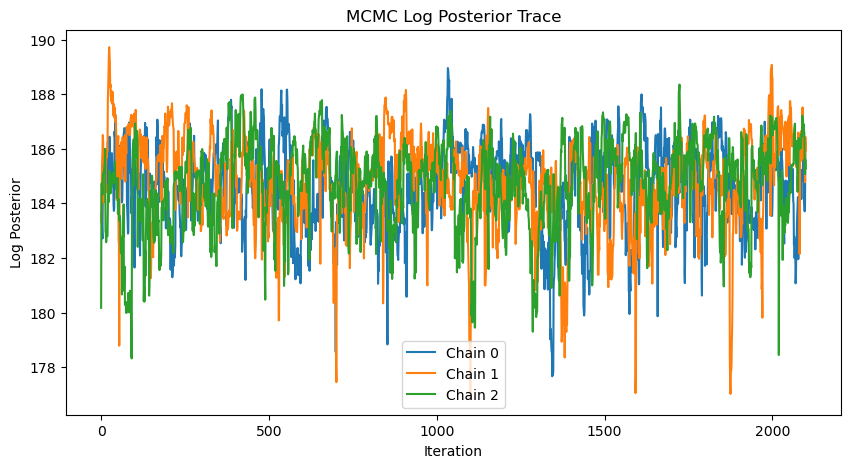

In [58]:
plot_log_posterior(chain_results, burnin_percent, save_path=save_path + f'/log_posterior_burnin_percent={burnin_percent}.png')

In [59]:
print([np.mean(result['acceptsigma']) for result in chain_results if result is not None])

[np.float64(0.32289236921026326), np.float64(0.31089636787737424), np.float64(0.31189603465511495)]


In [60]:
[np.mean(result['acceptalpha']) for result in chain_results if result is not None]

[np.float64(0.21226257914028657),
 np.float64(0.20759746751082972),
 np.float64(0.19293568810396536)]

In [61]:
[np.mean(result['acceptpath']) for result in chain_results if result is not None]

[np.float64(0.8323892035988004),
 np.float64(0.8387204265244919),
 np.float64(0.8337220926357881)]

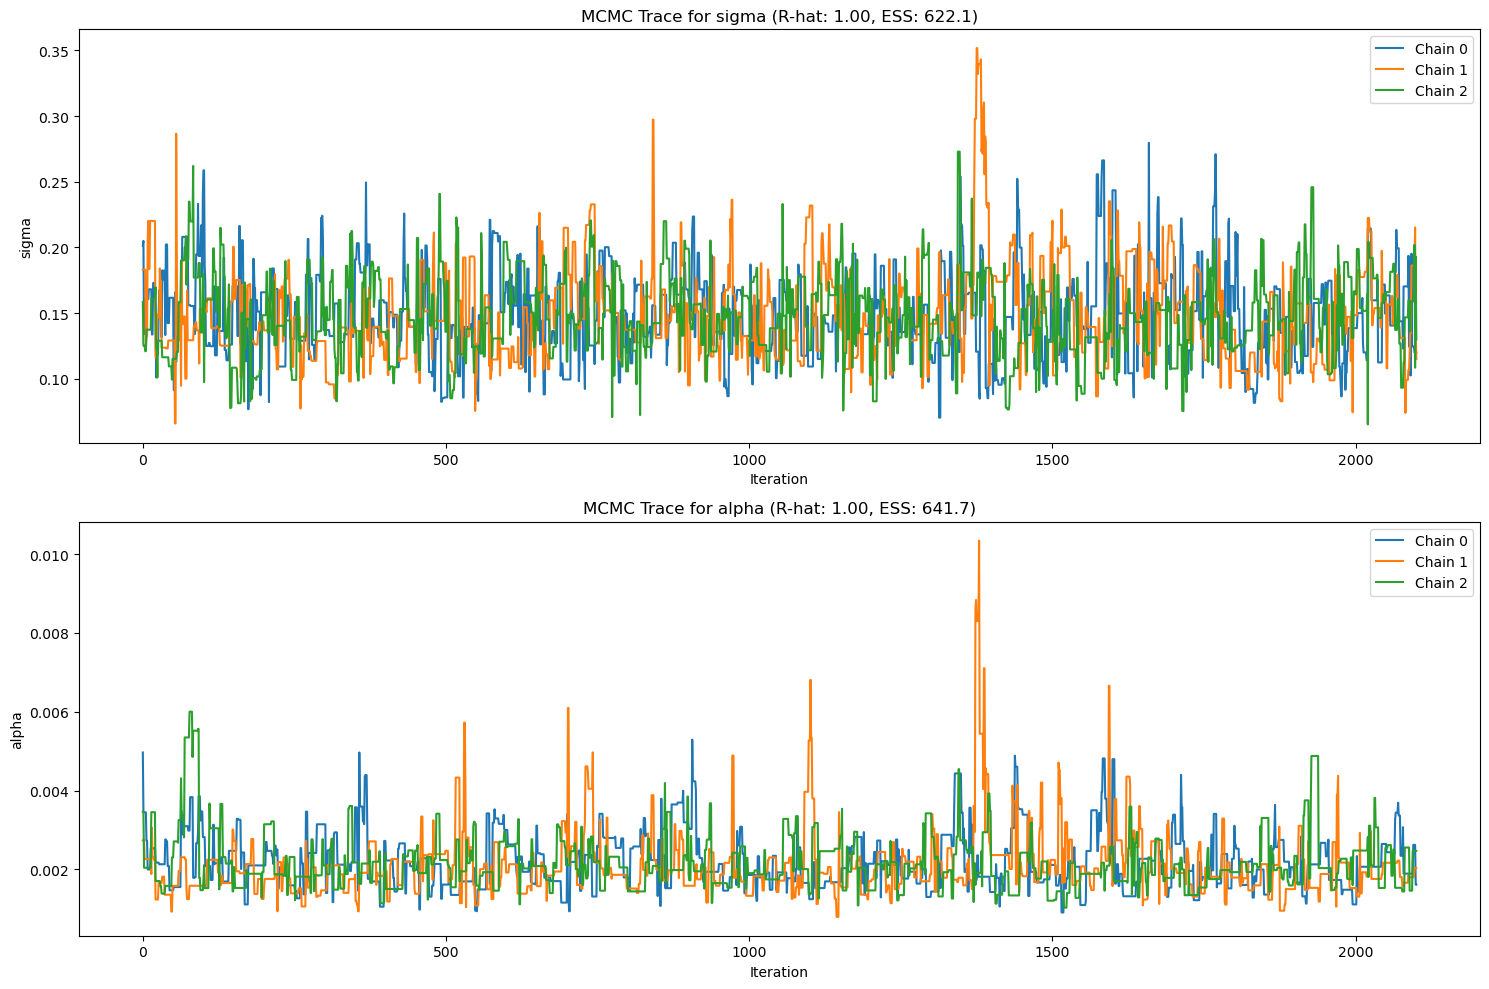

In [62]:
plot_parameter_traces(chain_results, param_names, burnin_percent, savepath=save_path + f'/parameter_traces_burnin_percent={burnin_percent}.png')

In [63]:
chain_results[0]['settings']

{'N': 3000,
 'dt': 0.05,
 'lambd': 0.95,
 'obs_var': 0.0001,
 'rb': 1.0,
 'seed_mcmc': 591278,
 'prior_sigma_min': 0.0,
 'prior_sigma_max': 1.0,
 'prior_alpha_min': 0.0,
 'prior_alpha_max': 0.05,
 'proposal_sigma_tau': 0.1,
 'proposal_alpha_tau': 0.005,
 'tree_string': '((0:4.1,1:4.1):3.5,(2:5.9,(3:4.2,4:4.2):1.7):1.7);',
 'outputpath': 'exp_1_sigma=0.7_alpha=0.025_dt=0.05/seed=121197884/mcmc/id=127107306',
 'use_wandb': True,
 'wandb_project': 'SPMS_MCMC'}

In [64]:
diagnostics = compute_diagnostics(chain_results, burnin_percent)

In [65]:
np.mean(chain_results[0]['alpha'])

np.float64(0.002245476052207082)

In [66]:
plot_traces(chain_results, burnin_percent, node_idx=[0, 1, 2, 6], save_path=save_path, diagnostics=diagnostics)

<Figure size 640x480 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

In [67]:
plot_samples_from_posterior(chain_results, burnin_percent=0.5, node_idx=[0, 1, 2, 6], sample_every=50, savepath=save_path, true_values=None)

Node 0: Found 273 samples, shape=(273, 40)
Node 1: Found 273 samples, shape=(273, 40)
Node 2: Found 273 samples, shape=(273, 40)
Node 6: Found 273 samples, shape=(273, 40)
Saved plots to exp_1_sigma=0.7_alpha=0.025_dt=0.05/seed=121197884/mcmc/id=127107306/plots/samples-posterior-sample_n=50_burnin_percent=0.5.pdf


# Look at posterior covariation

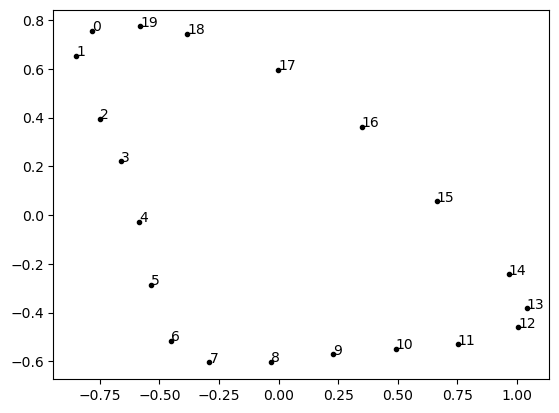

In [68]:
# visualize landmarks with labels 
flat_true_tree = np.genfromtxt(sim_path + "/flat_true_tree.csv", delimiter=',')   
plt.plot(flat_true_tree[0][0::2], flat_true_tree[0][1::2], '.', color='black', linewidth=2, label='true shape')
n = list(range(len(flat_true_tree[0][::2])))
for i, txt in enumerate(n):
    plt.annotate(txt, (flat_true_tree[0][::2][i], flat_true_tree[0][1::2][i]))

In [69]:
innernode_python = [0, 1, 2, 6]
innernode_R = [6,7,8,9]
node = 1
dim = [0, 2, 22]

# nchain x mcmc iter x nnodes x ndim
burnin_end = int(chain_results[0]['trees'].shape[0] * burnin_percent)
all_posterior_samples = np.array([chain_results[i]['trees'][burnin_end:,:,:] for i in range(len(chain_results)) if chain_results[i] is not None])
l0x = all_posterior_samples[:,:,node,dim[0]].flatten()
l1x = all_posterior_samples[:,:,node,dim[1]].flatten()
l12x = all_posterior_samples[:,:,node,dim[2]].flatten()

# load confidence intervals from folder 
conf_dim0 = pd.read_csv(sim_path + f"/fastAnc/95%_conf_trait{dim[0]+1}.csv", header=0, index_col=0)
conf_dim1 = pd.read_csv(sim_path + f"/fastAnc/95%_conf_trait{dim[1]+1}.csv", header=0, index_col=0)
conf_dim2 = pd.read_csv(sim_path + f"/fastAnc/95%_conf_trait{dim[2]+1}.csv", header=0, index_col=0)

In [70]:
def gaussian_kde_contour(x, y, levels=[0.05]):
    
    # Create kernel density estimate
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, bw_method=1)

    # Create a grid to evaluate the KDE
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= 0.1 * x_range
    x_max += 0.1 * x_range
    y_min -= 0.1 * y_range
    y_max += 0.1 * y_range
    x_grid, y_grid = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

    # Evaluate the KDE at the grid positions
    z = kde(positions).reshape(x_grid.shape)

    # Sort density values and find thresholds for specified levels
    z_flat = z.flatten()
    z_sorted = np.sort(z_flat)
    cumsum = np.cumsum(z_sorted)
    cumsum /= cumsum[-1]  # Normalize


    threshold_idx = np.searchsorted(cumsum, levels)
    threshold = z_sorted[threshold_idx]

    return x_grid, y_grid, z, threshold

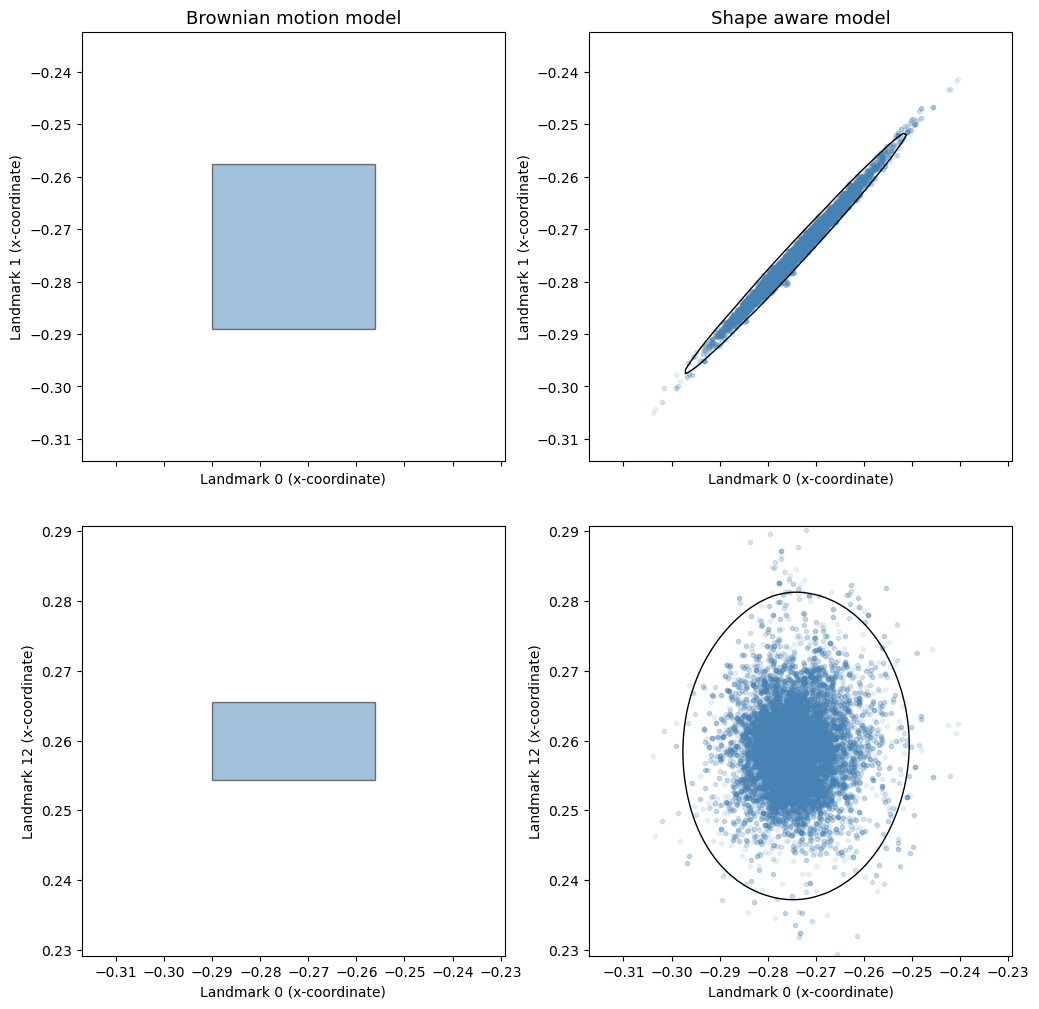

In [91]:
import matplotlib.patches as patches
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), sharex=True, sharey=False)
plt.subplots_adjust(wspace=0.2, hspace=0.15)
axes = axes.flatten()

axes[0].set_xlabel('Landmark 0 (x-coordinate)')
axes[0].set_ylabel('Landmark 1 (x-coordinate)')
axes[0].set_title('Brownian motion model', size=13)
x_min, x_max = conf_dim0.iloc[node, 0], conf_dim0.iloc[node, 1]; y_min, y_max = conf_dim1.iloc[node, 0], conf_dim1.iloc[node, 1]
padding = 0.8
x_range = x_max - x_min
y_range = y_max - y_min
axes[0].set_xlim(x_min - padding * x_range, x_max + padding * x_range)
axes[0].set_ylim(y_min - padding * y_range, y_max + padding * y_range)
rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                         linewidth=1, 
                         edgecolor='black', 
                         facecolor='steelblue', 
                         alpha=0.5)
axes[0].add_patch(rect)
#axes[0].text(x_max, y_min, "Region of interest", 
#             fontsize=9, 
#             color='black', 
#             va='bottom')
axes[1].set_xlim(x_min - padding * x_range, x_max + padding * x_range)
axes[1].set_ylim(y_min - padding * y_range, y_max + padding * y_range)
axes[1].set_xlabel('Landmark 0 (x-coordinate)')
axes[1].set_ylabel('Landmark 1 (x-coordinate)')
axes[1].set_title('Shape aware model', size=13)
axes[1].plot(l0x, l1x, '.', color='steelblue', alpha=0.1)
x_grid, y_grid, z, threshold = gaussian_kde_contour(l0x, l1x, levels=[0.05])
contour = axes[1].contour(x_grid, y_grid, z, levels=[threshold], 
                         colors='black', linewidths=1)
#axes[1].clabel(contour, inline=True, fontsize=10, fmt='%.2f')

padding=0.8
axes[2].set_xlabel('Landmark 0 (x-coordinate)')
axes[2].set_ylabel('Landmark 12 (x-coordinate)')
x_min, x_max = conf_dim0.iloc[node, 0], conf_dim0.iloc[node, 1]; y_min, y_max = conf_dim2.iloc[node, 0], conf_dim2.iloc[node, 1]
axes[2].set_xlim(x_min - padding * x_range, x_max + padding * x_range)
axes[2].set_ylim(y_min - padding * y_range, y_max + padding * y_range)
rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                         linewidth=1, 
                         edgecolor='black', 
                         facecolor='steelblue', 
                         alpha=.5)
axes[2].add_patch(rect)
axes[3].set_xlim(x_min - padding * x_range, x_max + padding * x_range)
axes[3].set_ylim(y_min - padding * y_range, y_max + padding * y_range)
axes[3].set_xlabel('Landmark 0 (x-coordinate)')
axes[3].set_ylabel('Landmark 12 (x-coordinate)')
axes[3].plot(l0x, l12x, '.', color='steelblue', alpha=0.1)
x_grid, y_grid, z, threshold = gaussian_kde_contour(l0x, l12x, levels=[0.05])
contour = axes[3].contour(x_grid, y_grid, z, levels=[threshold], 
                         colors='black', linewidths=1)
plt.savefig(save_path+"/posterior_covariation.pdf")